In [200]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True)

![function](dz-2.png)

In [201]:
def f(x, y):
    return x**2 + 2*y**2 + y

def f_grad(x, y) -> np.ndarray:
    return np.array([2*x, 4*y + 1])

def f_grad_2(x, y) -> np.ndarray:
    return np.array([[2, 0], [0, 4]])

starting_point = np.array([1, 2])
#argmin(f(x)) = (0, -1/4)
print(f(0, -1/4))

-0.125


In [202]:
class Optimization:
    def __init__(self, starting_point: np.ndarray, func: Callable, grad: Callable):
        self.point = starting_point
        self.points = [starting_point]
        self.directions = []
        self.loss = [func(*starting_point)]
        self.func = func
        self.grad = grad

    def redo(self, starting_point: np.ndarray):
        self.point = starting_point
        self.points = [starting_point]
        self.directions = []
        self.loss = [self.func(*starting_point)]

    def step(self, direction: np.ndarray, h: float):
        new_point = self.point + direction * h
        self.point = new_point
        self.directions.append(direction*h)
        self.points.append(new_point)
        self.loss.append(self.func(*new_point))

    def plot_phase_portrait(self, xlim=(-2.1, 2.1), ylim=(-2.1, 2.1), resolution=150, min_point=(0, -1/4)):
        x = np.linspace(xlim[0], xlim[1], resolution)
        y = np.linspace(ylim[0], ylim[1], resolution)
        X, Y = np.meshgrid(x, y)
        Z = np.array([self.func(*np.array([xx, yy])) for xx, yy in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=50, cmap='viridis')
        plt.colorbar(label='Function Value')

        points = np.array(self.points)
        directions = np.array(self.directions)
        plt.grid(True)
        plt.quiver(points[:-1, 0], points[:-1, 1], directions[:, 0], directions[:, 1], color='red', angles='xy', scale_units='xy', scale=1, width=0.007)
        plt.scatter(points[:, 0], points[:, 1], label='Optimization Path', s = 5, c = "white")
        plt.scatter(min_point[0], min_point[1], s = 7, c = "blue")

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Phase Portrait with Optimization Steps')
        plt.legend()
        plt.show()

opt = Optimization(starting_point, f, f_grad)

### Градиентный метод дробления шага

g: 11
g': [2 9]
step: 1
u: [0.8 1.1]
g: 4.16
g': [1.6 5.4]
step: 2
u: [0.64 0.56]
g: 1.5968000000000002
g': [1.28 3.24]


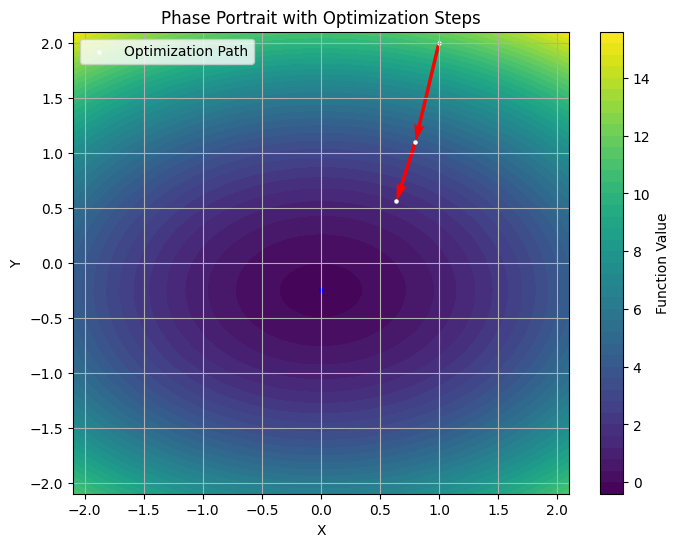

In [203]:
m = 2
alpha = 0.1
iter = 2

print("g:", f(*opt.point))
print("g':", f_grad(*opt.point))

for i in range(iter):
    print("step:", i + 1)
    opt.step(-f_grad(*opt.point), alpha)
    if opt.loss[-1] > opt.loss[-2]:
        alpha /= m
    print("u:", opt.point)
    print("g:", f(*opt.point))
    print("g':", f_grad(*opt.point))

opt.plot_phase_portrait()
opt.redo(starting_point)

### Метод наискорейшего спуска

step: 1
phi: 0.1189824452992354
alpha: 0.25582558255825605
u: [ 0.48835 -0.30243]
g: 0.1189824452992354
g': [ 0.9767  -0.20972]
step: 2
phi: -0.11996628705936452
alpha: 0.479047904790479
u: [ 0.02046 -0.20196]
g: -0.11996628705936452
g': [0.04093 0.19214]


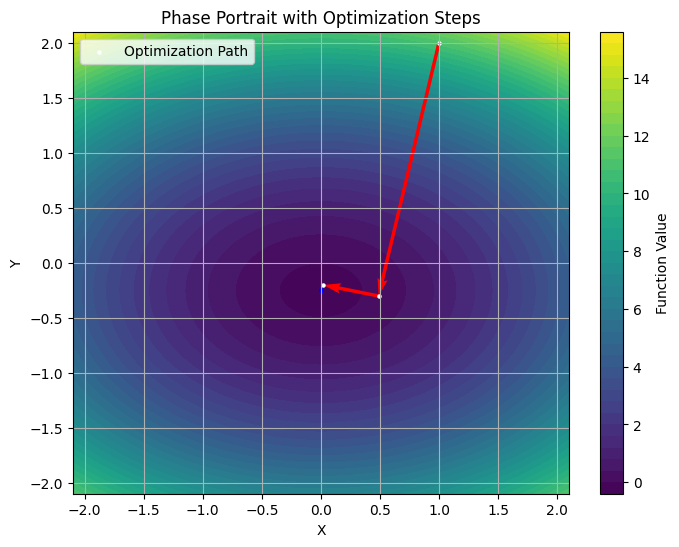

In [204]:
def phi(point: np.ndarray) -> tuple[float, float]:
    alphas = np.linspace(-2, 2, 10000)
    y = np.array([f( *(point - alpha*f_grad(*point))) for alpha in alphas], dtype=float)
    idx = np.argmin(y)
    alpha = alphas[idx]
    return y[idx], alpha

iter = 2

for i in range(iter):
    print("step:", i + 1)
    phi_, alpha = phi(opt.point)
    print("phi:", phi_)
    print("alpha:", alpha)

    opt.step(-f_grad(*opt.point), alpha)
    print("u:", opt.point)
    print("g:", f(*opt.point))
    print("g':", f_grad(*opt.point))

opt.plot_phase_portrait()
opt.redo(starting_point)

### Метод сопряжённых направлений

step: 1
phi: 0.11949587224862512
alpha: 0.2542542542542541
u: [ 0.49149 -0.28829]
g: 0.11949587224862512
g': [ 0.98298 -0.15315]
step: 2
r: [-0.98298  0.15315]
r_prev: [-2 -9]
u: [ 0.00495 -0.23408]
g: -0.12446856102764961
g': [0.0099  0.06368]


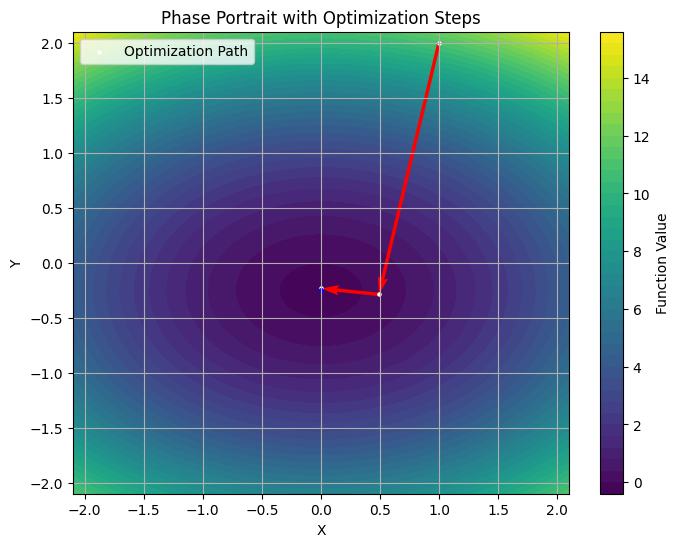

In [205]:
iter = 2
b = np.array([0, 1])
A = np.array([[2, 0], [0, 4]])

def phi(point: np.ndarray, grad: np.ndarray) -> tuple[float, float]:
    alphas = np.linspace(-2, 2, 1000)
    y = np.array([f( *(point + alpha * grad)) for alpha in alphas], dtype=float)
    idx = np.argmin(y)
    alpha = alphas[idx]
    return y[idx], alpha


for i in range(iter):
    print("step:", i + 1)
    if i == 0:
        phi_, alpha = phi(opt.point, -f_grad(*opt.point))
        print("phi:", phi_)
        print("alpha:", alpha)
        r = -f_grad(*opt.point)
        r = r #/ np.linalg.norm(r)
        dir_old = r

        opt.step(r, alpha)
    else:
        r = -f_grad(*opt.point)
        r = r #/ np.linalg.norm(r)
        r_prev = -f_grad(*opt.points[-2])
        r_prev = r_prev #/ np.linalg.norm(r_prev)
        print("r:", r)
        print("r_prev:", r_prev)
        w = ((r@ (r - r_prev)) / (r_prev@r_prev))
        direct = r + w * dir_old

        alpha = ((r @ r) / ((A@direct)@ direct))
        opt.step(direct, alpha)

        dir_old = direct

    print("u:", opt.point)
    print("g:", f(*opt.point))
    print("g':", f_grad(*opt.point))

opt.plot_phase_portrait()
opt.redo(starting_point)

### Метод Ньютона

g': [2 9]
g'':
 [[2 0]
 [0 4]]
step: 1
u: [ 0.   -0.25]
g': [0. 0.]
g'': [[2 0]
 [0 4]]
step: 2
u: [ 0.   -0.25]
g': [0. 0.]
g'': [[2 0]
 [0 4]]


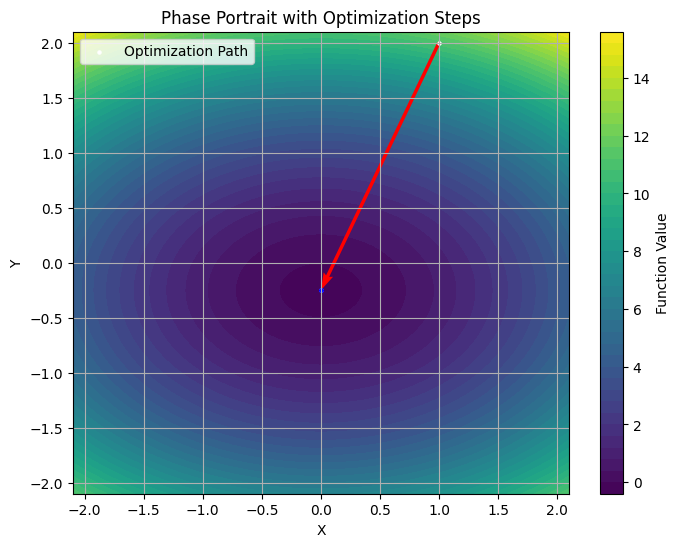

In [206]:
iter = 2
print("g':", f_grad(*opt.point))
print("g'':\n", f_grad_2(*opt.point))

for i in range(iter):
    print("step:", i + 1)
    opt.step(-np.linalg.inv(f_grad_2(*opt.point))@f_grad(*opt.point), 1)
    print("u:", opt.point)
    print("g':", f_grad(*opt.point))
    print("g'':", f_grad_2(*opt.point))

opt.plot_phase_portrait()
opt.redo(starting_point)

### Метод покоординатного спуска

g: 11
u: [1 2]
step: 1
u after Fx: [0. 2.]
g: 10.0
alpha: 0.5
u after Fy: [ 0.  -2.5]
g: 10.0
alpha: 0.25
step: 2
u after Fx: [ 0.  -2.5]
g: 10.0
alpha: 0.125
u after Fy: [ 0.    -1.375]
g: 2.40625
alpha: 0.125


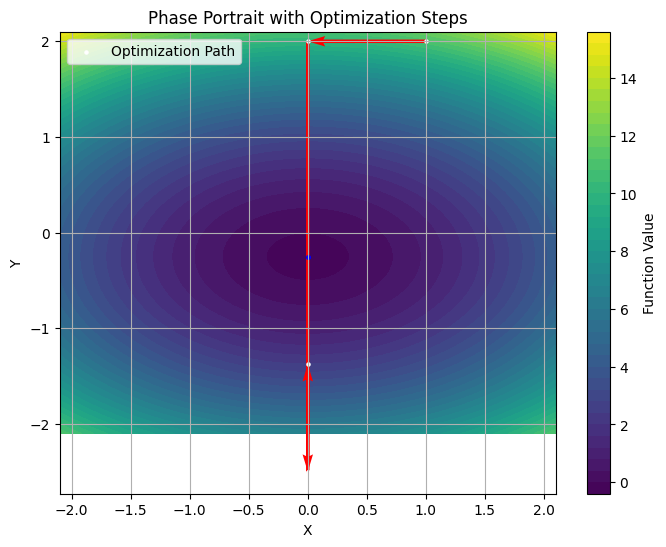

In [207]:
iter = 2
alpha = 0.5
lmb = 0.5
print("g:", f(*opt.point))
print("u:", opt.point)

for i in range(iter):
    print("step:", i + 1)
    new_grad = f_grad(*opt.point)
    new_grad[1] = 0
    opt.step(-new_grad, alpha)
    print("u after Fx:", opt.point)
    print("g:", f(*opt.point))
    if opt.loss[-1] >= opt.loss[-2]:
        alpha *= lmb
    print("alpha:", alpha)
    new_grad = f_grad(*opt.point)
    new_grad[0] = 0
    opt.step(-new_grad, alpha)
    print("u after Fy:", opt.point)
    print("g:", f(*opt.point))
    if opt.loss[-1] >= opt.loss[-2]:
        alpha *= lmb
    print("alpha:", alpha)

opt.plot_phase_portrait()
opt.redo(starting_point)